<a href="https://colab.research.google.com/github/DemonBrain/Tics1/blob/main/Probandi_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras.backend as K
import nltk
from tensorflow import keras
from keras.models import Model
from keras.optimizers import RMSprop
from keras.regularizers import l2
from keras.layers import Input, Embedding, Dense, Dropout, TimeDistributed, BatchNormalization, Bidirectional, LSTM, concatenate
from keras.layers import BatchNormalization, Lambda, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import tempfile

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import os
from sklearn.model_selection import train_test_split

In [4]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [5]:
nltk.download('stopwords')
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


--2023-06-21 21:41:42--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-21 21:41:42--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.10MB/s    in 2m 39s  

2023-06-21 21:44:22 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [6]:
# Cargar en una lista los nombres de los archivos csv
listCsv = [file for file in os.listdir() if file[-3:] == "csv"]

# Crear DataFrame vacio
df = pd.DataFrame()

# Recorrer la lista de archivos y unirlos
for file in listCsv:
    ftemp = pd.read_csv(file)
    df = pd.concat([df, ftemp], axis=0)
df

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( This ( church choir ) ) ( ( ( sings ( to (...,( ( The church ) ( ( has ( cracks ( in ( the c...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,(ROOT (S (NP (DT The) (NN church)) (VP (VBZ ha...,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,2677109430.jpg#1,2677109430.jpg#1r1n,neutral,contradiction,contradiction,neutral,neutral
1,entailment,( ( This ( church choir ) ) ( ( ( sings ( to (...,( ( The church ) ( ( is ( filled ( with song )...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,(ROOT (S (NP (DT The) (NN church)) (VP (VBZ is...,This church choir sings to the masses as they ...,The church is filled with song.,2677109430.jpg#1,2677109430.jpg#1r1e,entailment,entailment,entailment,neutral,entailment
2,contradiction,( ( This ( church choir ) ) ( ( ( sings ( to (...,( ( ( A choir ) ( singing ( at ( a ( baseball ...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,(ROOT (NP (NP (DT A) (NN choir)) (VP (VBG sing...,This church choir sings to the masses as they ...,A choir singing at a baseball game.,2677109430.jpg#1,2677109430.jpg#1r1c,contradiction,contradiction,contradiction,contradiction,contradiction
3,neutral,( ( ( A woman ) ( with ( ( ( ( ( a ( green hea...,( ( The woman ) ( ( is young ) . ) ),(ROOT (NP (NP (DT A) (NN woman)) (PP (IN with)...,(ROOT (S (NP (DT The) (NN woman)) (VP (VBZ is)...,"A woman with a green headscarf, blue shirt and...",The woman is young.,6160193920.jpg#4,6160193920.jpg#4r1n,neutral,neutral,neutral,neutral,neutral
4,entailment,( ( ( A woman ) ( with ( ( ( ( ( a ( green hea...,( ( The woman ) ( ( is ( very happy ) ) . ) ),(ROOT (NP (NP (DT A) (NN woman)) (PP (IN with)...,(ROOT (S (NP (DT The) (NN woman)) (VP (VBZ is)...,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,6160193920.jpg#4,6160193920.jpg#4r1e,entailment,entailment,contradiction,entailment,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,contradiction,( ( The man ) ( ( is ( on ( ( a ( ski boat ) )...,( ( The man ) ( ( fell down ) ( the stairs ) ) ),(ROOT (S (NP (DT The) (NN man)) (VP (VBZ is) (...,(ROOT (S (NP (DT The) (NN man)) (VP (VBD fell)...,The man is on a ski boat in the water.,The man fell down the stairs,3176968956.jpg#3,3176968956.jpg#3r1c,contradiction,NaN,NaN,NaN,NaN
179996,neutral,( ( The man ) ( ( is ( on ( ( a ( ski boat ) )...,( There ( ( 's ( ( a man ) ( on ( ( a ( ski bo...,(ROOT (S (NP (DT The) (NN man)) (VP (VBZ is) (...,(ROOT (S (NP (EX There)) (VP (VBZ 's) (NP (NP ...,The man is on a ski boat in the water.,There's a man on a ski boat in the lake.,3176968956.jpg#3,3176968956.jpg#3r2n,neutral,NaN,NaN,NaN,NaN
179997,contradiction,( ( The man ) ( ( is ( on ( ( a ( ski boat ) )...,( There ( ( is ( ( a ( woman ( playing tennis ...,(ROOT (S (NP (DT The) (NN man)) (VP (VBZ is) (...,(ROOT (S (NP (EX There)) (VP (VBZ is) (NP (NP ...,The man is on a ski boat in the water.,There is a woman playing tennis with her friend.,3176968956.jpg#3,3176968956.jpg#3r4c,contradiction,NaN,NaN,NaN,NaN
179998,neutral,( ( The man ) ( ( is ( on ( ( a ( ski boat ) )...,( ( The guy ) ( ( is ( ( taking ( ( a trip ) (...,(ROOT (S (NP (DT The) (NN man)) (VP (VBZ is) (...,(ROOT (S (NP (DT The) (NN guy)) (VP (VBZ is) (...,The man is on a ski boat in the water.,The guy is taking a trip in his boat to an isl...,3176968956.jpg#3,3176968956.jpg#3r5n,neutral,NaN,NaN,NaN,NaN


In [7]:
train, test = train_test_split(df, test_size = 0.10)

In [8]:
train

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
8170,entailment,( ( ( A ( old man ) ) ( blowing ( bubbles ( in...,( ( An ( old man ) ) ( ( is ourdoors ) . ) ),(ROOT (NP (NP (DT A) (JJ old) (NN man)) (VP (V...,(ROOT (S (NP (DT An) (JJ old) (NN man)) (VP (V...,A old man blowing bubbles in the park.,An old man is ourdoors.,4511110810.jpg#4,4511110810.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
162553,neutral,( ( Fireman ( in ( ( the bottom ) ( of ( ( ( a...,( ( ( Fireman ( in ( an ( open building ) ) ) ...,(ROOT (S (NP (NP (NNP Fireman)) (PP (IN in) (N...,(ROOT (NP (NP (NP (NNP Fireman)) (PP (IN in) (...,"Fireman in the bottom of an open building, one...",Fireman in an open building taking part in a t...,1424170200.jpg#0,1424170200.jpg#0r1n,neutral,NaN,NaN,NaN,NaN
87825,entailment,( ( The fishemen ) ( ( enjoy ( the ( warm day ...,( ( The fishemen ) ( ( enjoys ( the weather ) ...,(ROOT (S (NP (DT The) (NN fishemen)) (VP (VBP ...,(ROOT (S (NP (DT The) (NN fishemen)) (VP (VBZ ...,The fishemen enjoy the warm day.,The fishemen enjoys the weather outside,2030781555.jpg#2,2030781555.jpg#2r1e,entailment,entailment,entailment,entailment,entailment
148848,entailment,( ( Three adults ) ( ( are ( watching ( at ( (...,( ( Three adults ) ( ( are ( watch ( a ( girl ...,(ROOT (S (NP (CD Three) (NNS adults)) (VP (VBP...,(ROOT (S (NP (CD Three) (NNS adults)) (VP (VBP...,Three adults are watching at a girl in a pit o...,Three adults are watch a girl play.,3669635757.jpg#2,3669635757.jpg#2r1e,entailment,NaN,NaN,NaN,NaN
160241,contradiction,( ( ( ( A family ) or ) ( ( a group ) ( of fri...,( ( A family ) ( ( are ( sitting ( doing nothi...,(ROOT (S (NP (NP (DT A) (NN family)) (CC or) (...,(ROOT (S (NP (DT A) (NN family)) (VP (VBP are)...,A family or a group of friends are having a pi...,A family are sitting doing nothing.,195137262.jpg#1,195137262.jpg#1r1c,contradiction,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81638,neutral,( ( A ( young man ) ) ( ( ( rides ( a skateboa...,( ( The ( young man ) ) ( successfully ( rode ...,(ROOT (S (NP (DT A) (JJ young) (NN man)) (VP (...,(ROOT (S (NP (DT The) (JJ young) (NN man)) (VP...,A young man rides a skateboard along a metal p...,The young man successfully rode the metal pole,3549140234.jpg#2,3549140234.jpg#2r1n,neutral,NaN,NaN,NaN,NaN
132810,contradiction,( ( Three men ) ( ( are ( ( ( ( working up ) f...,( ( Three men ) ( ( are ( ( riding waves ) ( o...,(ROOT (S (NP (CD Three) (NNS men)) (VP (VBP ar...,(ROOT (S (NP (CD Three) (NNS men)) (VP (VBP ar...,Three men are working up fish on a stainless s...,Three men are riding waves on surfboards.,4345676156.jpg#2,4345676156.jpg#2r5c,contradiction,NaN,NaN,NaN,NaN
108803,neutral,( ( ( A family ) ( consisting ( of ( ( ( ( ( a...,( ( ( ( Two adults ) and ) children ) ( ( get ...,(ROOT (S (NP (NP (DT A) (NN family)) (VP (VBG ...,(ROOT (S (NP (NP (CD Two) (NNS adults)) (CC an...,"A family consisting of a man, woman and two bo...",Two adults and children get ready to attend th...,4811949932.jpg#0,4811949932.jpg#0r1n,neutral,NaN,NaN,NaN,NaN
58911,entailment,( ( Welders ( ( working ( at night ) ) with ) ...,( ( The welders ) ( ( are ( working ( with mac...,(ROOT (S (NP (NP (NNS Welders)) (VP (VBG worki...,(ROOT (S (NP (DT The) (NNS welders)) (VP (VBP ...,Welders working at night with sparks flying.,The welders are working with machines.,3350185126.jpg#3,3350185126.jpg#3r4e,entailment,NaN,NaN,NaN,NaN


In [9]:
test_F, valid_F = train_test_split(test, test_size = 0.50)

In [10]:
test_F

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
142828,entailment,( ( Two ( young girls ) ) ( ( are ( enjoying (...,( ( the girls ) ( are ( ( moving down ) ( the ...,(ROOT (S (NP (CD Two) (JJ young) (NNS girls)) ...,(ROOT (S (NP (DT the) (NNS girls)) (VP (VBP ar...,Two young girls are enjoying riding down a hil...,the girls are moving down the hill,5223651213.jpg#0,5223651213.jpg#0r1e,entailment,NaN,NaN,NaN,NaN
62423,entailment,( ( Four ( young boys ) ) ( ( ( ( perform ( in...,( ( Four boys ) ( ( are ( playing music ) ) . ) ),(ROOT (S (NP (CD Four) (JJ young) (NNS boys)) ...,(ROOT (S (NP (CD Four) (NNS boys)) (VP (VBP ar...,"Four young boys perform in their band, singing...",Four boys are playing music.,340027203.jpg#0,340027203.jpg#0r1e,entailment,NaN,NaN,NaN,NaN
57718,entailment,( ( People ( watching ( an ( interesting thing...,( People ( watching ( an ( interesting thing )...,(ROOT (NP (NP (NNS People)) (VP (VBG watching)...,(ROOT (NP (S (NP (NNS People)) (VP (VBG watchi...,People watching an interesting thing.,People watching an interesting thing,506432952.jpg#3,506432952.jpg#3r1e,entailment,NaN,NaN,NaN,NaN
50118,neutral,( ( ( Three ( baseball players ) ) ( either ( ...,( ( The team ) ( ( is ( playing ( in ( the ( w...,(ROOT (NP (NP (CD Three) (NN baseball) (NNS pl...,(ROOT (S (NP (DT The) (NN team)) (VP (VBZ is) ...,Three baseball players either playing a game o...,The team is playing in the world series.,7173223829.jpg#1,7173223829.jpg#1r1n,neutral,NaN,NaN,NaN,NaN
2538,entailment,( People ( ( are ( ( gathered ( by ( a tree ) ...,( People ( ( are ( gathered ( near ( ( a tree ...,(ROOT (S (NP (NNS People)) (VP (VBP are) (VP (...,(ROOT (S (NP (NNS People)) (VP (VBP are) (VP (...,People are gathered by a tree beside a line of...,People are gathered near a tree in proximity o...,3480051754.jpg#3,3480051754.jpg#3r1e,entailment,entailment,entailment,entailment,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43232,entailment,( ( Two girls ) ( ( ( walk ( through ( ( a tun...,( ( The girls ) ( are ( walking ( through ( th...,(ROOT (S (NP (CD Two) (NNS girls)) (VP (VBP wa...,(ROOT (S (NP (DT The) (NNS girls)) (VP (VBP ar...,Two girls walk through a tunnel with red and y...,The girls are walking through the tunnel,4773735551.jpg#0,4773735551.jpg#0r1e,entailment,NaN,NaN,NaN,NaN
41567,entailment,( ( A woman ) ( ( is ( ( sitting down ) ( with...,( ( A woman ) ( ( has ( a bag ) ) . ) ),(ROOT (S (NP (DT A) (NN woman)) (VP (VBZ is) (...,(ROOT (S (NP (DT A) (NN woman)) (VP (VBZ has) ...,A woman is sitting down with her bag.,A woman has a bag.,2077649684.jpg#4,2077649684.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
65142,contradiction,( ( A ( police force ) ) ( ( donned ( in ( ( f...,( ( The ( police force ) ) ( is naked ) ),(ROOT (S (NP (DT A) (NN police) (NN force)) (V...,(ROOT (S (NP (DT The) (NN police) (NN force)) ...,A police force donned in full gear are crossin...,The police force is naked,3855280083.jpg#2,3855280083.jpg#2r4c,contradiction,NaN,NaN,NaN,NaN
117286,entailment,( ( ( A man ) ( in ( a ( bright ( ( ( yellow a...,( ( A man ) ( is ( demonstrating something ) ) ),(ROOT (S (NP (NP (DT A) (NN man)) (PP (IN in) ...,(ROOT (S (NP (DT A) (NN man)) (VP (VBZ is) (VP...,A man in a bright yellow and orange safety ves...,A man is demonstrating something,5062544126.jpg#0,5062544126.jpg#0r1e,entailment,NaN,NaN,NaN,NaN


In [11]:
#@title Lectura de datos
df_entrenamiento = train
df_pruebas = test_F
df_validacion = valid_F

In [12]:
df_pruebas

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
142828,entailment,( ( Two ( young girls ) ) ( ( are ( enjoying (...,( ( the girls ) ( are ( ( moving down ) ( the ...,(ROOT (S (NP (CD Two) (JJ young) (NNS girls)) ...,(ROOT (S (NP (DT the) (NNS girls)) (VP (VBP ar...,Two young girls are enjoying riding down a hil...,the girls are moving down the hill,5223651213.jpg#0,5223651213.jpg#0r1e,entailment,NaN,NaN,NaN,NaN
62423,entailment,( ( Four ( young boys ) ) ( ( ( ( perform ( in...,( ( Four boys ) ( ( are ( playing music ) ) . ) ),(ROOT (S (NP (CD Four) (JJ young) (NNS boys)) ...,(ROOT (S (NP (CD Four) (NNS boys)) (VP (VBP ar...,"Four young boys perform in their band, singing...",Four boys are playing music.,340027203.jpg#0,340027203.jpg#0r1e,entailment,NaN,NaN,NaN,NaN
57718,entailment,( ( People ( watching ( an ( interesting thing...,( People ( watching ( an ( interesting thing )...,(ROOT (NP (NP (NNS People)) (VP (VBG watching)...,(ROOT (NP (S (NP (NNS People)) (VP (VBG watchi...,People watching an interesting thing.,People watching an interesting thing,506432952.jpg#3,506432952.jpg#3r1e,entailment,NaN,NaN,NaN,NaN
50118,neutral,( ( ( Three ( baseball players ) ) ( either ( ...,( ( The team ) ( ( is ( playing ( in ( the ( w...,(ROOT (NP (NP (CD Three) (NN baseball) (NNS pl...,(ROOT (S (NP (DT The) (NN team)) (VP (VBZ is) ...,Three baseball players either playing a game o...,The team is playing in the world series.,7173223829.jpg#1,7173223829.jpg#1r1n,neutral,NaN,NaN,NaN,NaN
2538,entailment,( People ( ( are ( ( gathered ( by ( a tree ) ...,( People ( ( are ( gathered ( near ( ( a tree ...,(ROOT (S (NP (NNS People)) (VP (VBP are) (VP (...,(ROOT (S (NP (NNS People)) (VP (VBP are) (VP (...,People are gathered by a tree beside a line of...,People are gathered near a tree in proximity o...,3480051754.jpg#3,3480051754.jpg#3r1e,entailment,entailment,entailment,entailment,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43232,entailment,( ( Two girls ) ( ( ( walk ( through ( ( a tun...,( ( The girls ) ( are ( walking ( through ( th...,(ROOT (S (NP (CD Two) (NNS girls)) (VP (VBP wa...,(ROOT (S (NP (DT The) (NNS girls)) (VP (VBP ar...,Two girls walk through a tunnel with red and y...,The girls are walking through the tunnel,4773735551.jpg#0,4773735551.jpg#0r1e,entailment,NaN,NaN,NaN,NaN
41567,entailment,( ( A woman ) ( ( is ( ( sitting down ) ( with...,( ( A woman ) ( ( has ( a bag ) ) . ) ),(ROOT (S (NP (DT A) (NN woman)) (VP (VBZ is) (...,(ROOT (S (NP (DT A) (NN woman)) (VP (VBZ has) ...,A woman is sitting down with her bag.,A woman has a bag.,2077649684.jpg#4,2077649684.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
65142,contradiction,( ( A ( police force ) ) ( ( donned ( in ( ( f...,( ( The ( police force ) ) ( is naked ) ),(ROOT (S (NP (DT A) (NN police) (NN force)) (V...,(ROOT (S (NP (DT The) (NN police) (NN force)) ...,A police force donned in full gear are crossin...,The police force is naked,3855280083.jpg#2,3855280083.jpg#2r4c,contradiction,NaN,NaN,NaN,NaN
117286,entailment,( ( ( A man ) ( in ( a ( bright ( ( ( yellow a...,( ( A man ) ( is ( demonstrating something ) ) ),(ROOT (S (NP (NP (DT A) (NN man)) (PP (IN in) ...,(ROOT (S (NP (DT A) (NN man)) (VP (VBZ is) (VP...,A man in a bright yellow and orange safety ves...,A man is demonstrating something,5062544126.jpg#0,5062544126.jpg#0r1e,entailment,NaN,NaN,NaN,NaN


In [13]:
columnas = ['sentence1','sentence2','gold_label']
entrenamiento = df_entrenamiento[columnas]
pruebas = df_pruebas[columnas]
validacion = df_validacion[columnas]

entrenamiento.dropna(axis = 0, inplace = True)
pruebas.dropna(axis = 0, inplace = True)
validacion.dropna(axis = 0, inplace = True)

<ipython-input-13-ab25479910e7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entrenamiento.dropna(axis = 0, inplace = True)
<ipython-input-13-ab25479910e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruebas.dropna(axis = 0, inplace = True)
<ipython-input-13-ab25479910e7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacion.dropna(axis = 0, inplace = True)


In [14]:

entrenamiento = entrenamiento.loc[entrenamiento['gold_label'] != "-"]
entrenamiento = entrenamiento.loc[entrenamiento['gold_label'] != "neutral"]

pruebas = pruebas.loc[pruebas['gold_label'] != "-"]
pruebas = pruebas.loc[pruebas['gold_label']!= "neutral"]
pruebas


,sentence1,sentence2,gold_label
142828,Two young girls are enjoying riding down a hil...,the girls are moving down the hill,entailment
62423,"Four young boys perform in their band, singing...",Four boys are playing music.,entailment
57718,People watching an interesting thing.,People watching an interesting thing,entailment
2538,People are gathered by a tree beside a line of...,People are gathered near a tree in proximity o...,entailment
162534,A kickboxer delivers a side kick to a heavy ba...,"A kickboxer is sitting on a mat, resting.",contradiction
...,...,...,...
43232,Two girls walk through a tunnel with red and y...,The girls are walking through the tunnel,entailment
41567,A woman is sitting down with her bag.,A woman has a bag.,entailment
65142,A police force donned in full gear are crossin...,The police force is naked,contradiction
117286,A man in a bright yellow and orange safety ves...,A man is demonstrating something,entailment


In [15]:
mapeo_label = {
    "neutral":0,
    "contradiction":1,
    "entailment":2
}
entrenamiento['gold_label'] = entrenamiento['gold_label'].map(mapeo_label)
pruebas['gold_label'] = pruebas['gold_label'].map(mapeo_label)

<ipython-input-15-e8734eef50a6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entrenamiento['gold_label'] = entrenamiento['gold_label'].map(mapeo_label)


In [16]:
#@title Limpieza de datos
def limpiarTexto(texto):
  texto = str(texto).lower()
  texto = re.sub('\[.*?\]', '', texto)
  texto = re.sub('<.*?>+', '', texto)
  texto = re.sub('\n', '', texto)
  texto = re.sub('[%s]' % re.escape(string.punctuation), '', texto)
  texto = re.sub('\w*\d\w*', '', texto)
  return texto

entrenamiento['sentence1'] = entrenamiento['sentence1'].apply(limpiarTexto)
entrenamiento['sentence2'] = entrenamiento['sentence2'].apply(limpiarTexto)

pruebas['sentence2'] = pruebas['sentence2'].apply(limpiarTexto)
pruebas['sentence1'] = pruebas['sentence1'].apply(limpiarTexto)

pruebas

,sentence1,sentence2,gold_label
142828,two young girls are enjoying riding down a hil...,the girls are moving down the hill,2
62423,four young boys perform in their band singing ...,four boys are playing music,2
57718,people watching an interesting thing,people watching an interesting thing,2
2538,people are gathered by a tree beside a line of...,people are gathered near a tree in proximity o...,2
162534,a kickboxer delivers a side kick to a heavy ba...,a kickboxer is sitting on a mat resting,1
...,...,...,...
43232,two girls walk through a tunnel with red and y...,the girls are walking through the tunnel,2
41567,a woman is sitting down with her bag,a woman has a bag,2
65142,a police force donned in full gear are crossin...,the police force is naked,1
117286,a man in a bright yellow and orange safety ves...,a man is demonstrating something,2


In [17]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
entrenamiento['sentence1'] = entrenamiento['sentence1'].apply(remove_stopwords)
entrenamiento['sentence2'] = entrenamiento['sentence2'].apply(remove_stopwords)

pruebas['sentence1'] = pruebas['sentence1'].apply(remove_stopwords)
pruebas['sentence2'] = pruebas['sentence2'].apply(remove_stopwords)

pruebas

,sentence1,sentence2,gold_label
142828,two young girls enjoying riding hill snow,girls moving hill,2
62423,four young boys perform band singing playing g...,four boys playing music,2
57718,people watching interesting thing,people watching interesting thing,2
2538,people gathered tree beside line white tents,people gathered near tree proximity white tents,2
162534,kickboxer delivers side kick heavy bag gym,kickboxer sitting mat resting,1
...,...,...,...
43232,two girls walk tunnel red yellow items pull air,girls walking tunnel,2
41567,woman sitting bag,woman bag,2
65142,police force donned full gear crossing street,police force naked,1
117286,man bright yellow orange safety vest showing w...,man demonstrating something,2


In [18]:
#stemmer VEREMOS SI SE APLICA O NO

In [19]:
#@title Tokenización
tokens_entrenamiento = np.asarray([entrenamiento['sentence1'],entrenamiento['sentence2']])
tokens_entrenamiento = tokens_entrenamiento.reshape(-1,1)
tokens_prueba = np.asarray([pruebas['sentence1'],pruebas['sentence2']])
tokens_entrenamiento = tokens_entrenamiento.reshape(tokens_entrenamiento.shape[0])

In [20]:
tokenizador = Tokenizer(num_words = 6000)
tokenizador.fit_on_texts(tokens_entrenamiento)
tokenizador

In [21]:
premisa = tokenizador.texts_to_sequences(entrenamiento['sentence1'])
premisa = pad_sequences(premisa)

hipotesis = tokenizador.texts_to_sequences(entrenamiento['sentence2'])
hipotesis = pad_sequences(hipotesis, maxlen=premisa.shape[1])


In [22]:
premisa_prueba = tokenizador.texts_to_sequences(pruebas['sentence1'])
premisa_prueba = pad_sequences(premisa_prueba,45)

hipotesis_prueba = tokenizador.texts_to_sequences(pruebas['sentence2'])
hipotesis_prueba = pad_sequences(hipotesis_prueba,maxlen = premisa_prueba.shape[1])

etiquetas_prueba = to_categorical(pruebas['gold_label'])

In [23]:
#@title Etiquetas
etiquetas = to_categorical(entrenamiento['gold_label'])
etiquetas

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [24]:
#@title Embedding
vocabulario = len(tokenizador.word_index)

def gloveWork(archivo,vocabulario):
  #Se crea un diccionario palabra-vector de un modelo preentrenado(Glove)
  embeddings_index = {}
  file_ = open(archivo)
  for line in file_:
      arr = line.split()
      palabra = arr[0]
      vector = np.asarray(arr[1:],dtype='float32')
      embeddings_index[palabra] = vector
  file_.close()

  tam_maximo = vocabulario +1
  indices_palabras = tokenizador.word_index
  embedding_matriz = np.zeros((tam_maximo,300)).astype(object)

  for palabrax, indice in indices_palabras.items():
    vector_entrenado = embeddings_index.get(palabrax)
    if vector_entrenado is not None:
      embedding_matriz[indice] = vector_entrenado

  return embedding_matriz


In [25]:
matriz_embedding = gloveWork('glove.6B.300d.txt',vocabulario)

In [26]:
matriz_embedding.shape

(18838, 300)

In [42]:
#@title Hiperparámetros
dropout = 0.2
L2 = 4e-6
learning_rate = 0.01
paciencia = 4
rho = 0.9
epsilon = 1e-08
decay = 0.0
validacion_split = 0.02
epoch = 20

In [43]:
embedding = Embedding(input_dim=matriz_embedding.shape[0],
                          output_dim=300,
                          weights=[matriz_embedding],
                          input_length=42,
                          trainable=False)
BiLSTM = Bidirectional(LSTM(64))
translation = TimeDistributed(Dense(300, activation='relu'))
premise = Input(shape=(45,), dtype='int32')
hypothesis = Input(shape=(45,), dtype='int32')
premise_embedded = embedding(premise)
hypothesis_embedded = embedding(hypothesis)
premise_translated = translation(premise_embedded)
hypothesis_translated = translation(hypothesis_embedded)
premise_BiLSTM = BiLSTM(premise_translated)
hypothesis_BiLSTM = BiLSTM(hypothesis_translated)
premise_normalized = BatchNormalization()(premise_BiLSTM)
hypothesis_normalized = BatchNormalization()(hypothesis_BiLSTM)

train_input = concatenate([premise_normalized, hypothesis_normalized])
train_input = Dropout(dropout)(train_input)
# Apply the (Dense layer, Dropout layer. Batch normalization layer) unit : 1
train_input = Dense(2 * 300, activation='relu', kernel_regularizer=l2(L2))(train_input)
train_input = Dropout(dropout)(train_input)
train_input = BatchNormalization()(train_input)

# Apply the (Dense layer, Dropout layer. Batch normalization layer) unit : 2
train_input = Dense(2 * 300, activation='relu', kernel_regularizer=l2(L2))(train_input)
train_input = Dropout(dropout)(train_input)
train_input = BatchNormalization()(train_input)

# Apply the (Dense layer, Dropout layer. Batch normalization layer) unit : 3
train_input = Dense(2 * 300, activation='relu', kernel_regularizer=l2(L2))(train_input)
train_input = Dropout(dropout)(train_input)
train_input = BatchNormalization()(train_input)

prediction = Dense(3, activation='softmax')(train_input)
model = Model(inputs=[premise, hypothesis], outputs=prediction)
optimizer = RMSprop(lr=learning_rate, rho=rho, epsilon=epsilon, decay=decay)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 45, 300)      5651400     ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 45, 300)     90300       ['embedding_1[0][0]',      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [44]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=paciencia,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss',patience=paciencia)
_, tmpfn = tempfile.mkstemp()
model_checkpoint = ModelCheckpoint(tmpfn, save_best_only=True, save_weights_only=True)
callbacks = [early_stopping, model_checkpoint, learning_rate_reduction]

history = model.fit(x=[premisa, hipotesis],
                    y=etiquetas,
                    batch_size=512,
                    epochs=epoch,
                    validation_split=validacion_split,
                    callbacks=callbacks)


Epoch 1/20
230/230 [==============================] - 23s 61ms/step - loss: 0.7554 - accuracy: 0.6719 - val_loss: 0.6004 - val_accuracy: 0.7114 - lr: 0.0100
Epoch 2/20
230/230 [==============================] - 10s 45ms/step - loss: 0.5161 - accuracy: 0.7611 - val_loss: 1.5043 - val_accuracy: 0.5942 - lr: 0.0100
Epoch 3/20
230/230 [==============================] - 8s 37ms/step - loss: 0.4528 - accuracy: 0.7951 - val_loss: 0.7837 - val_accuracy: 0.7515 - lr: 0.0100
Epoch 4/20
230/230 [==============================] - 9s 38ms/step - loss: 0.4224 - accuracy: 0.8136 - val_loss: 0.7931 - val_accuracy: 0.5605 - lr: 0.0100
Epoch 5/20
230/230 [==============================] - 9s 38ms/step - loss: 0.4053 - accuracy: 0.8230 - val_loss: 0.4066 - val_accuracy: 0.8224 - lr: 0.0100
Epoch 6/20
230/230 [==============================] - 8s 37ms/step - loss: 0.3883 - accuracy: 0.8307 - val_loss: 0.5352 - val_accuracy: 0.7531 - lr: 0.0100
Epoch 7/20
230/230 [==============================] - 8s 37ms/

In [45]:
datos_prueba = [premisa_prueba, hipotesis_prueba]
evaluacion = model.evaluate(datos_prueba,etiquetas_prueba)

210/210 [==============================] - 1s 7ms/step - loss: 0.4303 - accuracy: 0.8289


In [65]:
datos_prueba

[array([[   0,    0,    0, ...,   36,  228,   70],
        [   0,    0,    0, ...,    8,   95, 1737],
        [   0,    0,    0, ...,   60, 2031, 2129],
        ...,
        [   0,    0,    0, ...,  364,  463,   23],
        [   0,    0,    0, ...,   10,   61,  122],
        [   0,    0,    0, ...,  492, 1064,  393]], dtype=int32),
 array([[   0,    0,    0, ...,   47,  454,  228],
        [   0,    0,    0, ...,   63,    8,  207],
        [   0,    0,    0, ...,   60, 2031, 2129],
        ...,
        [   0,    0,    0, ...,  319, 3480,  524],
        [   0,    0,    0, ...,    1, 1803,   78],
        [   0,    0,    0, ...,  730, 2114,   93]], dtype=int32)]

In [72]:
etiquetas_prueba.shape

(6703, 3)

In [81]:
etiquetas_prueba

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [51]:
Y_pred = model.predict(datos_prueba)
print(Y_pred)

210/210 [==============================] - 3s 6ms/step
[[1.6102991e-05 3.0219474e-01 6.9778919e-01]
 [3.5674798e-06 2.7498654e-01 7.2500986e-01]
 [8.0768143e-07 2.1027176e-01 7.8972745e-01]
 ...
 [3.5154294e-06 8.1881344e-01 1.8118306e-01]
 [2.2947093e-05 3.2501224e-01 6.7496485e-01]
 [4.2513831e-05 3.5862836e-01 6.4132911e-01]]


In [71]:
Y_pred.shape


(6703, 3)

In [74]:
y_pred = np.argmax(Y_pred, axis=1)
y_pred.shape

(6703,)

In [80]:
y_test = np.argmax(etiquetas_prueba, axis=1)
print(y_test)

[2 2 2 ... 1 2 2]


In [53]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

ValueError: ignored

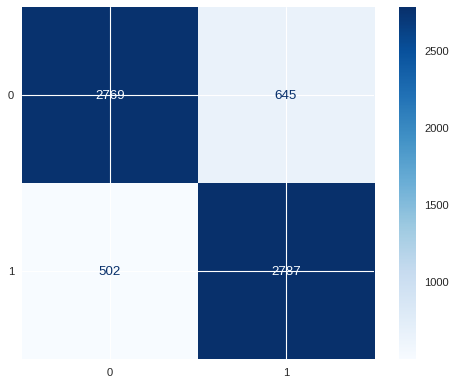

In [79]:
cm = confusion_matrix(y_test, y_pred)

lables = ["neutral","contradiction","entailment"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lables)

disp.plot(cmap=plt.cm.Blues)
plt.show()

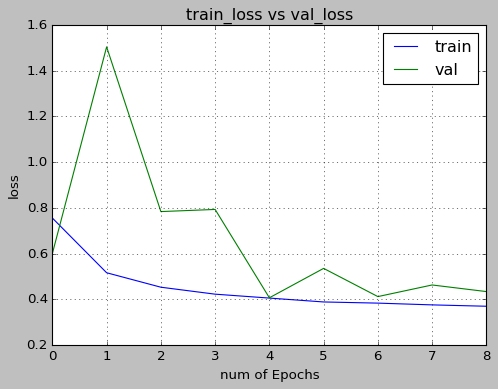

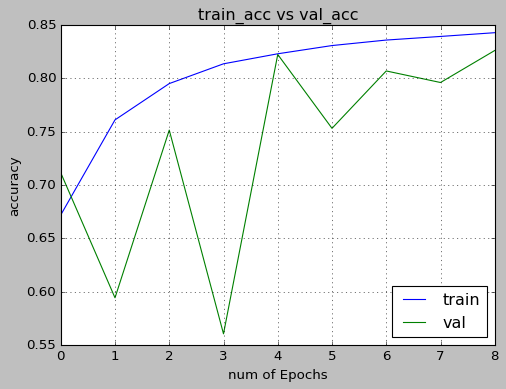

In [47]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
xc=range(9)
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [67]:
import matplotlib as mpl
def draw_plot(data,c, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (20, 6))
  plt.plot(data,c, label= type_data)
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()

<ipython-input-67-235b6aa75655>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


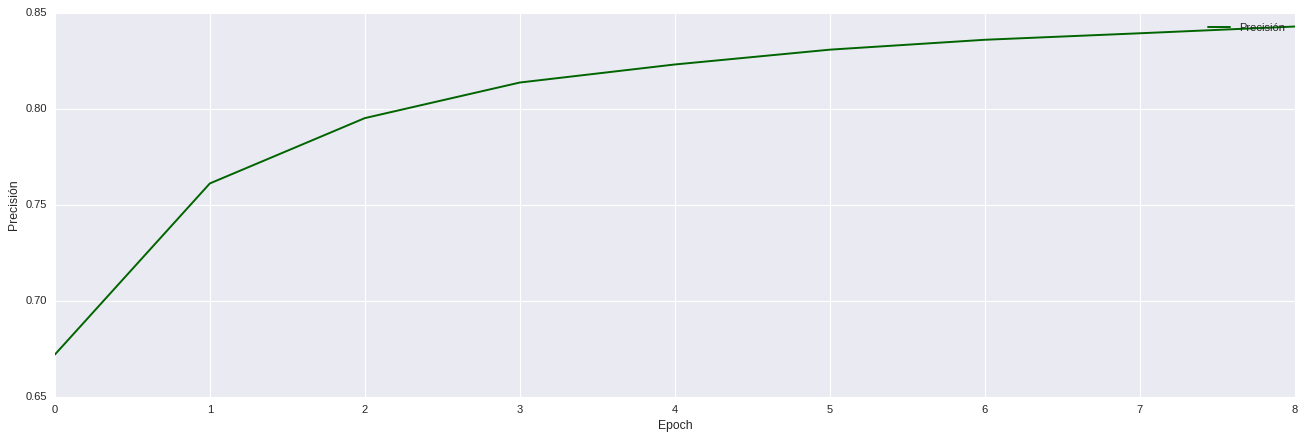

In [68]:
draw_plot(history.history['accuracy'],"darkgreen", "Precisión")

<ipython-input-67-235b6aa75655>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


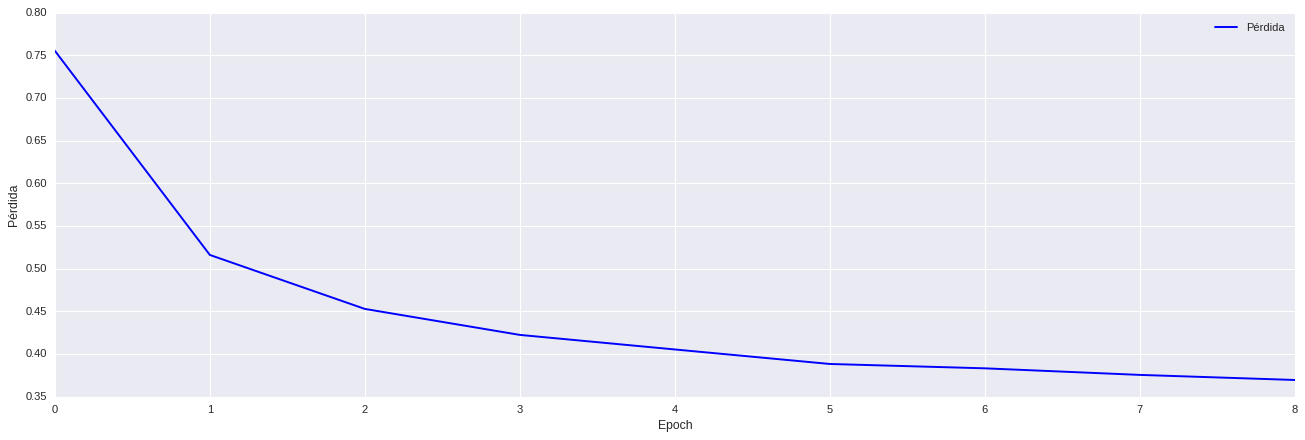

In [69]:
draw_plot(history.history['loss'],"blue", "Pérdida")